### Importación de los módulos necesarios

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pmdarima.arima import ndiffs, nsdiffs
from datetime import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from dateutil.relativedelta import relativedelta
from metricas import calculo_metricas

import warnings
warnings.simplefilter("ignore")

# Mostramos las versiones de los módulos para posibles reproducciones del código

print('Versión pandas:', pd.__version__)
print('Versión numpy:', np.__version__)
print('Versión matplotlib:', matplotlib.__version__)
print('Version statsmodels', sm.__version__)

Versión pandas: 1.0.5
Versión numpy: 1.19.5
Versión matplotlib: 3.2.2
Version statsmodels 0.12.2


### Lectura del dataframe horario

In [2]:
df = pd.read_csv('Data/dataframe.csv', index_col = 0)
df.index = pd.to_datetime(df.index)
#df = df.drop(columns = ["Festivo_Regional", "Humedad_Relativa", "Precipitacion", "Radiacion", "Velocidad_Viento"])

df.loc[:, "lag_24"] = df.Spot_electricidad.shift(24)
df.loc[:, "lag_48"] = df.Spot_electricidad.shift(48)
df.loc[:, "lag_1_semana"] = df.Spot_electricidad.shift(24*7)

### Modelo regresión lineal

In [3]:
db = df.dropna()
# db = db.drop(columns = ["Prevision_Demanda", "Prevision_Eol_Fotov", "Festivo_Regional", "Brent",
#                        "Humedad_Relativa", "Precipitacion", "Radiacion"])
# db = db.drop(columns = ["Prevision_Demanda", "Prevision_Eol_Fotov", "Festivo_Regional", "Brent",
#                        "Humedad_Relativa", "Precipitacion", "Radiacion", "Velocidad_Viento"])
db = db.dropna()
X = sm.add_constant(db)
y = X.pop('Spot_electricidad')

model = sm.OLS(y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Spot_electricidad   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                 1.180e+04
Date:                Tue, 31 May 2022   Prob (F-statistic):               0.00
Time:                        21:22:17   Log-Likelihood:            -1.0160e+05
No. Observations:               26256   AIC:                         2.033e+05
Df Residuals:                   26206   BIC:                         2.037e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.3856      1.246     -1.914      0.056      -4.828       0.057
Prevision_Demanda    5.289e-05   2.04e-05      2.589      0.010    1.29e-05    9.29e-05
Prevision_Eol_Fotov    -0.0010   1.74e-05    -56.330      0.000      -0.001      -0.001
Hueco_Termico           0.0010   1.29e-05     79.817      0.000       0.001       0.001
Lunes                   3.1370      0.263     11.946      0.000       2.622       3.652
Martes                  0.0676      0.274      0.247      0.805      -0.469       0.604
Miercoles              -0.4344      0.264     -1.646      0.100      -0.952       0.083
Jueves                  0.7784      0.266      2.926      0.003       0.257       1.300
Viernes                -0.9309      0.262     -3.556      0.000      -1.444      -0.418
Sabado                 -2.2106      0.237     -9.321      0.000      -2.675      -1.746
Domingo                -2.7928      0.239    -11.680      0.000      -3.261      -2.324
Hora_1                  0.3418      0.368      0.929      0.353      -0.379       1.063
Hora_2                 -0.9943      0.382     -2.600      0.009      -1.744      -0.245
Hora_3                 -2.0906      0.398     -5.258      0.000      -2.870      -1.311
Hora_4                 -2.9651      0.409     -7.257      0.000      -3.766      -2.164
Hora_5                 -3.3393      0.415     -8.049      0.000      -4.152      -2.526
Hora_6                 -2.6783      0.413     -6.493      0.000      -3.487      -1.870
Hora_7                 -1.7367      0.398     -4.365      0.000      -2.516      -0.957
Hora_8                 -0.7401      0.385     -1.922      0.055      -1.495       0.015
Hora_9                  0.0339      0.374      0.091      0.928      -0.700       0.768
Hora_10                 0.7482      0.365      2.049      0.040       0.032       1.464
Hora_11                 0.6802      0.377      1.805      0.071      -0.058       1.419
Hora_12                 0.5094      0.405      1.259      0.208      -0.284       1.303
Hora_13                 0.7152      0.432      1.656      0.098      -0.131       1.562
Hora_14                 0.4134      0.451      0.917      0.359      -0.470       1.297
Hora_15                -0.1014      0.444     -0.228      0.819      -0.971       0.768
Hora_16                -0.6987      0.422     -1.655      0.098      -1.526       0.129
Hora_17                -0.4063      0.405     -1.003      0.316      -1.200       0.387
Hora_18                 0.9656      0.391      2.467      0.014       0.198       1.733
Hora_19                 2.0963      0.382      5.489      0.000       1.348       2.845
Hora_20                 2.8622      0.386      7.417      0.000       2.106       3.619
Hora_21                 2.2893      0.391      5.859      0.000       1.524       3.055
Hor

### Backtesting regresión lineal

In [4]:
def bascktesting_regresion_lineal(db, año, mes, rolling_window, days_start):
    
    """Función que realiza un backtesting del modelo de regresión lineal.
    Parametros:
        - db: dataframe con la variable a explicar y las variables explicativas
        - año: año desde el que se quiere comenzar a realizar el backtesting
        - mes: mes desde el que se quiere comenzar a realizar el backtesting
        - rolling_window: valor booleano que describe si quieres ventana de entrenamiento móvil o no
        - days_start: en caso de que rolling window sea True, coge los días de la ventana móvil fija de entrenamiento
    output:
        - array_pred: vector de valores de predicción
        - array_real: vector de valores reales con los que se compara la predicción
        - array_date: fechas horarias a las que corresponde los valores reales y predichos
    
    """
    
    fecha = datetime(año, mes, 1)
    fecha_str = str(año) + '-' + str(mes) + '-' + str(1)
    
    db = db.dropna()
    array_real, array_pred, array_date = np.zeros(len(db.loc[fecha_str:])), np.zeros(len(db.loc[fecha_str:])), []

    # En caso de que haya rolling window
    if rolling_window == True:
        for day in range(int(len(db.loc[fecha_str:]) / 24)):
            fecha_end_train = fecha + relativedelta(days = day)
            fecha_start_train = fecha_end_train - relativedelta(days = days_start)
            fecha_end_train = str(fecha_end_train.year) + "-" + str(fecha_end_train.month) + "-" + str(fecha_end_train.day)
            fecha_start_train = str(fecha_start_train.year) + "-" + str(fecha_start_train.month) + "-" + str(fecha_start_train.day)
            db_aux = db.loc[fecha_start_train:fecha_end_train]
            
            # Dataframe de Entrenamiento
            X_train = sm.add_constant(db_aux)
            y_train = X_train.pop('Spot_electricidad')
            
            # Dataframe de Test
            X_test = X_train.loc[fecha_end_train]
            y_test = y_train.pop(fecha_end_train)

            # Quitamos al dataframe de train, el dataframe de test
            X_train = X_train.drop(index = X_train.iloc[-24:].index)

            # Entrenamos el modelo
            model = sm.OLS(y_train, X_train).fit()
            
            # Realizamos las predicciones
            pred = model.predict(X_test)
            date = pred.index

            array_date.append(date)
            array_pred[day*24:day*24 + 24] = pred
            array_real[day*24:day*24 + 24] = y_test
        
    # En caso de que no haya rolling window, siempre cogemos todo el dataframe disponible
    else:
        for day in range(int(len(db.loc[fecha_str:]) / 24)):
            fecha_end_train = fecha + relativedelta(days = day)
            fecha_end_train = str(fecha_end_train.year) + "-" + str(fecha_end_train.month) + "-" + str(fecha_end_train.day)
            db_aux = db.loc[:fecha_end_train]

            # Dataframe de Entrenamiento
            X_train = sm.add_constant(db_aux)
            y_train = X_train.pop('Spot_electricidad')
            
            # Dataframe de Test
            X_test = X_train.loc[fecha_end_train]
            y_test = y_train.pop(fecha_end_train)
            
            # Quitamos al dataframe de train, el dataframe de test
            X_train = X_train.drop(index = X_train.iloc[-24:].index)
            
            # Entrenamos el modelo
            model = sm.OLS(y_train, X_train).fit()
            
            # Realizamos las predicciones
            pred = model.predict(X_test)
            date = pred.index

            array_date.append(date)
            array_pred[day*24:day*24 + 24] = pred
            array_real[day*24:day*24 + 24] = y_test
            
    array_date = [item for sublist in array_date for item in sublist]
    return array_pred, array_real, array_date
    
pred, real, dates = bascktesting_regresion_lineal(db.loc["2019":], 2021, 1, rolling_window = True, days_start = 220)

### Cálculo de las métricas

In [5]:
resultados = pd.DataFrame({"Pred":pred, "Real":real}, index = dates)
resultados["Pred"][resultados.loc[:, "Pred"] < 0] = 0


reg_lineal, reg_lineal_metricas_mensuales, met = calculo_metricas(resultados)

     MAE  MAE (median)    MAPE  WMAPE   RMSE  % Trend
0  10.21          6.78  122.39   9.12  16.59    83.99


###  Análisis de los residuos del mejor modelo escogido

Diferencia regular: 0
Diferencia estacional: 0


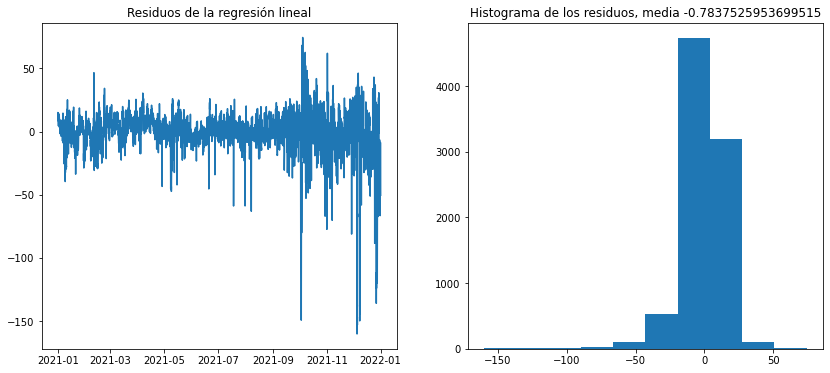

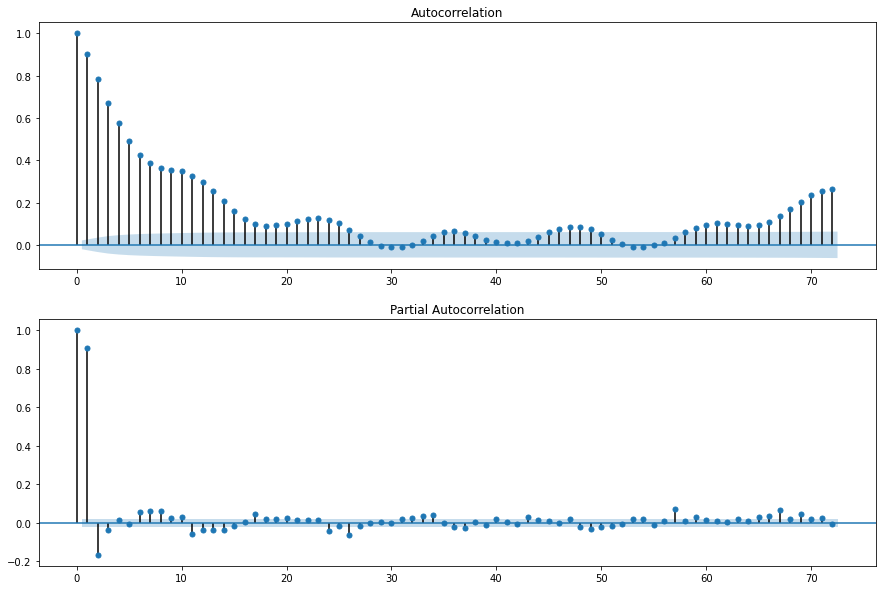

In [6]:
y_residuos = reg_lineal.Real - reg_lineal.Pred

print('Diferencia regular:', ndiffs(y_residuos, alpha = 0.05, test = 'adf'))
print('Diferencia estacional:', nsdiffs(y_residuos, m = 24, test = 'ocsb'))

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,6))
ax1.plot(y_residuos)
ax1.set_title('Residuos de la regresión lineal')
ax2.hist(y_residuos)
ax2.set_title('Histograma de los residuos, media {0}'.format(y_residuos.mean()))
plt.show()
nlags = 72 # play with this parameter

fig, ax = plt.subplots(2,1, figsize = (15,10))
plot_acf(y_residuos, lags = nlags,  ax=ax[0])
plot_pacf(y_residuos, lags = nlags, method="ols",ax=ax[1])
plt.show()
    
# Como vemos, hay mucha información aún que se puede recoger con los residuos. Aplicamos un SARIMA a los residuos

### Análisis del SARIMA aplicado a los residuos de la regresión lineal

Diferencia regular: 0
Diferencia estacional: 0


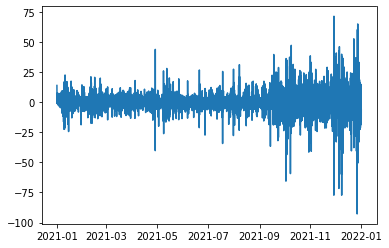

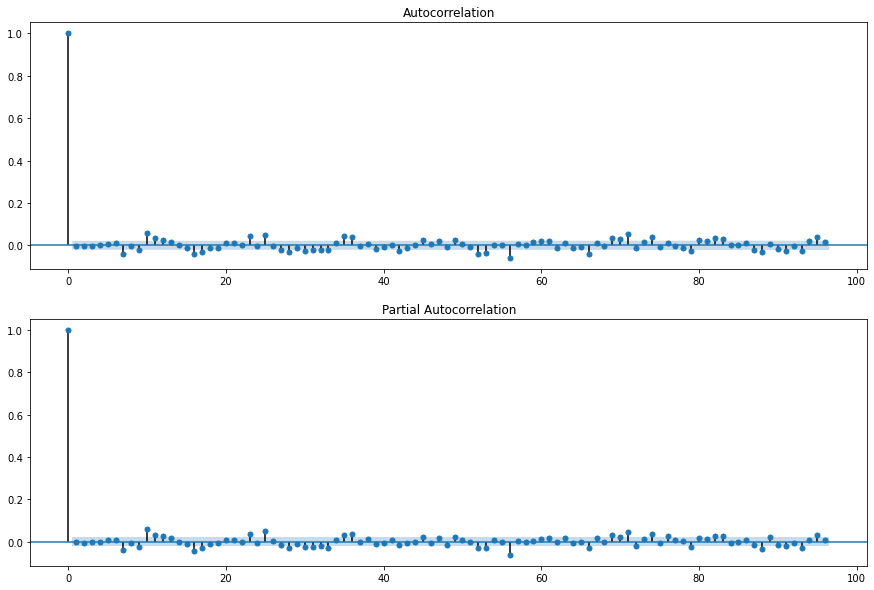

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
modelo = SARIMAX(endog = y_residuos, order = (7,0,0), seasonal_order= (3,0,0,24)).fit(method = 'lbfgs', disp = False)

# Nos quedamos con los residuos
reg_residuos = modelo.resid

print('Diferencia regular:', ndiffs(reg_residuos, alpha = 0.05, test = 'adf'))
print('Diferencia estacional:', nsdiffs(reg_residuos, m = 24, test = 'ocsb'))
plt.plot(reg_residuos)
plt.show()
nlags = 96 # play with this parameter

fig, ax = plt.subplots(2,1, figsize = (15,10))
plot_acf(reg_residuos, lags = nlags,  ax=ax[0])
plot_pacf(reg_residuos, lags = nlags, method="ols",ax=ax[1])
plt.show()


### Aplicamos ahora un SARIMA a los residuos del modelo de la regresión lineal

In [ ]:
def bascktesting_sarima(db, año, mes, rolling_window, days_start):
    
    """Función que realiza un backtesting del modelo SARIMA.
    Parametros:
        - db: dataframe con la variable a explicar y las variables explicativas
        - año: año desde el que se quiere comenzar a realizar el backtesting
        - mes: mes desde el que se quiere comenzar a realizar el backtesting
        - rolling_window: valor booleano que describe si quieres ventana de entrenamiento móvil o no
        - days_start: en caso de que rolling window sea True, coge los días de la ventana móvil fija de entrenamiento
    output:
        - array_pred: vector de valores de predicción
        - array_real: vector de valores reales con los que se compara la predicción
        - array_date: fechas horarias a las que corresponde los valores reales y predichos
    
    """
    fecha = datetime(año, mes, 1)
    fecha_str = str(año) + '-' + str(mes) + '-' + str(1)
    
    array_real, array_pred, array_date = np.zeros(len(db.loc[fecha_str:])), np.zeros(len(db.loc[fecha_str:])), []
    
    fecha = datetime(año, mes, 1)
    fecha_str = str(año) + '-' + str(mes) + '-' + str(1)
    
    db = db.dropna()
    array_real, array_pred, array_date = np.zeros(len(db.loc[fecha_str:])), np.zeros(len(db.loc[fecha_str:])), []

    # En caso de que haya rolling window
    if rolling_window == True:
        for day in range(int(len(db.loc[fecha_str:]) / 24)):
            fecha_end_train = fecha + relativedelta(days = day)
            fecha_start_train = fecha_end_train - relativedelta(days = days_start)
            fecha_end_train = str(fecha_end_train.year) + "-" + str(fecha_end_train.month) + "-" + str(fecha_end_train.day)
            fecha_start_train = str(fecha_start_train.year) + "-" + str(fecha_start_train.month) + "-" + str(fecha_start_train.day)
            db_aux = db.loc[fecha_start_train:fecha_end_train]
            
            # Dataframe de Entrenamiento
            y_train = db_aux
            
            # Dataframe de Test
            y_test = y_train.pop(fecha_end_train)

            # Entrenamos el modelo
            model = SARIMAX(endog = y_train, order = (7,0,0), seasonal_order= (3,0,0,24)).fit(method = 'lbfgs', disp = False)

            pred = model.forecast(24)
            date = [str(i) for i in pred.index]
            array_date.append(date)
            array_pred[day*24:day*24 + 24] = pred.values
            array_real[day*24:day*24 + 24] = y_test
            print(day)

            
        
    # En caso de que no haya rolling window, siempre cogemos todo el dataframe disponible
    else:
        for day in range(int(len(db.loc[fecha_str:]) / 24)):
            fecha_end_train = fecha + relativedelta(days = day)
            fecha_end_train = str(fecha_end_train.year) + "-" + str(fecha_end_train.month) + "-" + str(fecha_end_train.day)
            db_aux = db.loc[:fecha_end_train]

            # Dataframe de Entrenamiento
            X_train = sm.add_constant(db_aux)
            y_train = X_train.pop('Price')
            
            # Dataframe de Test
            X_test = X_train.loc[fecha_end_train]
            y_test = y_train.pop(fecha_end_train)
            
            # Quitamos al dataframe de train, el dataframe de test
            X_train = X_train.drop(index = X_train.iloc[-24:].index)
            
            # Entrenamos el modelo
            model = SARIMAX(endog = y_train, exog = X_train,  order = (7,0,0), seasonal_order= (3,0,0,24)).fit(method = 'lbfgs', disp = False)

            pred = model.forecast(24, exog = X_test)
            
            date = [str(i) for i in pred.index]
            array_date.append(date)
            array_pred[day*24:day*24 + 24] = pred.values
            array_real[day*24:day*24 + 24] = y_test
            print(day)
            
    array_date = [item for sublist in array_date for item in sublist]
    return array_pred, array_real, array_date

    
pred, real, dates = bascktesting_sarima(model.resid, 2021, 1, rolling_window = True, days_start = 30)

### Calculo de las metricas

In [44]:
resultados_res = pd.DataFrame({"Pred":pred, "Real":real}, index = dates)
resultados_res["Pred"][resultados_res.loc[:, "Pred"] < 0] = 0

resultados_sar_reg = pd.DataFrame({"Pred":resultados["Pred"] + resultados_res["Pred"],
                                   "Real":resultados["Real"]})

reg_lineal, reg_lineal_metricas_mensuales, met = calculo_metricas(resultados_sar_reg)